# Prática Guiada - Modelagem estatística II.

# Plano de aula 

#### Faremos um ciclo do início ao fim de tudo que aprendemos até aqui nas próximas duas aulas com um mesmo dataset. A primeira aula será concentrada no [EDA](https://www.ibm.com/cloud/learn/exploratory-data-analysis#:~:text=Exploratory%20data%20analysis%20(EDA)%20is,often%20employing%20data%20visualization%20methods.&text=It%20can%20also%20help%20determine,for%20data%20analysis%20are%20appropriate.). A segunda aula na [modelagem](https://www.ibm.com/garage/method/practices/reason/model-selection-development-ai-data-science/).

# Introdução do caso

<br>
<img src="img/house_price.png" width="950" />
<br>

No nosso exemplo vamos modelar uma regressão para explicar os preços das casas nos EUA.

    -> Identificar como a base foi construida
    -> Devemos nos preocupar os com outliers?
    -> Ao analisar como as variáveis estão distribuidas, temos funções conhecidas?
    -> Como as funções se correlacionam, os comportamentos são os previstos?
    -> Para estudar a correlação parcial com regressões precisamos mudar a forma dos dados?
    -> Variáveis dummies, quando usa-las
    -> Iterando váriaveis
    -> Gerando predições
    
Features:
- **price** - The last price the house was sold for
- **num_bed** - The number of bedrooms
- **num_bath** - The number of bathrooms (fractions mean the house has a toilet-only or shower/bathtub-only bathroom)
- **size_house** (includes basement) - The size of the house
- **size_lot** - The size of the lot
- **num_floors** - The number of floors
- **is_waterfront** - Whether or not the house is a waterfront house (0 means it is not a waterfront house whereas 1 means that it is a waterfront house)
- **condition** - How worn out the house is. Ranges from 1 (needs repairs all over the place) to 5 (the house is very well maintained)
- **size_basement** - The size of the basement
- **year_built** - The year the house was built
- **renovation_date** - The year the house was renovated for the last time. 0 means the house has never been renovated
- **zip** - The zip code
- **latitude** - Latitude
- **longitude** - Longitude
- **avg_size_neighbor_houses** - The average house size of the neighbors
- **avg_size_neighbor_lot** - The average lot size of the neighbors

O dataset foi simplificado para a aula (algumas features foram excluídas). Dados originais disponíveis no Kaggle [clicando aqui](https://www.kaggle.com/harlfoxem/housesalesprediction)

--------------

# Aula 2 - Modelagem

## Importando os pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Leitura dos dados

In [2]:
%time 
house_prices = pd.read_csv("house_pricing.csv", 
                           delimiter = ',' 
                          )
house_prices.head()

Wall time: 0 ns


,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,239000,3,1.0,1510,15022,1.0,0,3,0,1962,0,98003,47.330433,-122.303609,1510,12970
1,1260000,3,3.5,3220,3960,2.0,0,3,460,1991,0,98116,47.590933,-122.384230,3080,4444
2,414500,3,1.0,1050,6002,1.0,0,3,210,1941,0,98115,47.698761,-122.316010,1180,6003
3,252500,3,2.5,1780,7192,1.0,0,4,530,1974,0,98031,47.409319,-122.173484,1870,8500
4,389000,3,1.0,1330,3740,1.5,0,3,0,1903,0,98118,47.550242,-122.274232,1330,5053


## Feature Selection.

#### O trabalho de [seleção de atributos](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e) é o de procurar identificar as variáveis mais promissoras para o modelo. É necessário ir além de considerar apenas correlações, deve-se pensar na complexidade do processo (dummização, variáveis confusas).

#### Vamos plotar um mapa de calor para a [matriz de correlações](https://www.displayr.com/what-is-a-correlation-matrix/#:~:text=A%20correlation%20matrix%20is%20a,a%20diagnostic%20for%20advanced%20analyses.) com todas as variáveis, gerando uma máscara de valores. Para isso aplicamos o método [`.triu()`](https://numpy.org/doc/stable/reference/generated/numpy.triu.html) para definir o triângulo superior da matriz de correlação.

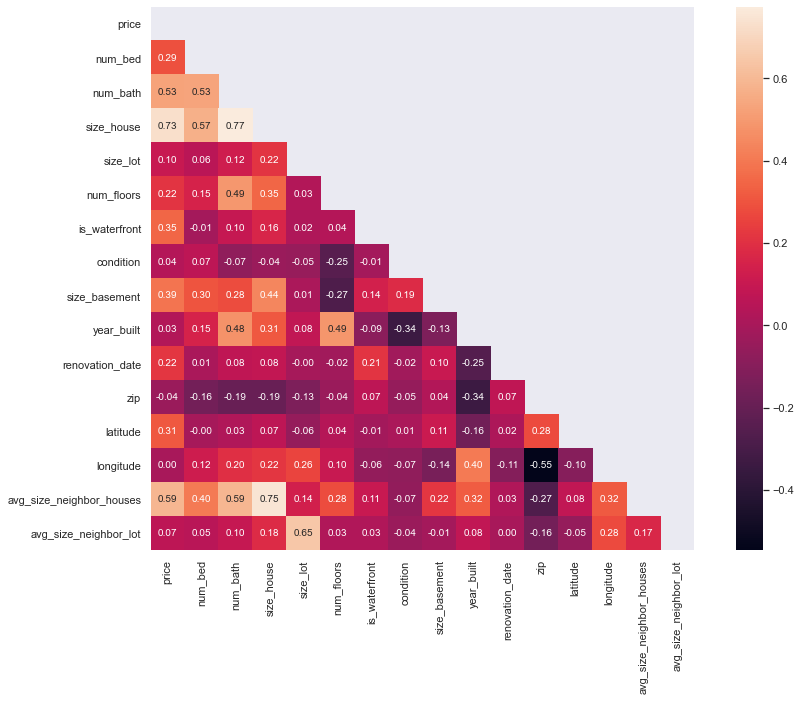

In [3]:
corrmat = house_prices.corr()

sns.set(font_scale = 1.0)

f, ax = plt.subplots(figsize = (15, 10))


mask = np.triu(np.ones_like(corrmat, 
                            dtype = bool
                           )
              )

hm = sns.heatmap(corrmat, 
                 mask = mask,
                 cbar = True, # formatando a barra lateral de cores para o heatmap
                 annot = True, 
                 square = True, 
                 fmt = '.2f', 
                 annot_kws = {'size': 10}, 
                 yticklabels = corrmat.columns, 
                 xticklabels = corrmat.columns
                )

#### Agora vamos valores nulos usando o método [`.replace()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html).

In [4]:
corrmat_lower = (corrmat * ~mask).replace({0.0: np.nan}).round(2)
#type(corrmat * ~mask)
corrmat_lower

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_bed,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_bath,0.53,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size_house,0.73,0.57,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size_lot,0.10,0.06,0.12,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_floors,0.22,0.15,0.49,0.35,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_waterfront,0.35,-0.01,0.10,0.16,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,0.04,0.07,-0.07,-0.04,-0.05,-0.25,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size_basement,0.39,0.30,0.28,0.44,0.01,-0.27,0.14,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_built,0.03,0.15,0.48,0.31,0.08,0.49,-0.09,-0.34,-0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Agora vamos empilhar os níveis prescritos das colunas para o índice usando o método [`.stack()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.stack.html) que retorna um `DataFrame` ou `Series` remodelado com um índice de vários níveis com um ou mais novos níveis mais internos em comparação com o `DataFrame` original. Os novos níveis mais internos são criados girando as colunas do `dataframe` original

In [5]:
#type(corrmat)
corrmat.stack(dropna = True)

price                  price                       1.000000
                       num_bed                     0.290632
                       num_bath                    0.530072
                       size_house                  0.728505
                       size_lot                    0.102039
                                                     ...   
avg_size_neighbor_lot  zip                        -0.157729
                       latitude                   -0.053513
                       longitude                   0.275739
                       avg_size_neighbor_houses    0.168315
                       avg_size_neighbor_lot       1.000000
Length: 256, dtype: float64

#### O mapa de calor ajuda nos primeiros `insights`, mas podemos criar uma lista com as relações mais relevantes, ordenando nossas variáveis por ordem de correlação umas com as outras.

In [6]:
corr_list = abs(corrmat_lower).stack(dropna = True)\
                              .reset_index()\
                              .rename({'level_0':'var_1', 
                                       'level_1':'var_2', 
                                       0:'corr'}, 
                                      axis = 1
                                     )\
                              .sort_values(by = 'corr', 
                                           ascending = False
                                          )\
                              .head(20)
corr_list

,var_1,var_2,corr
5,size_house,num_bath,0.77
94,avg_size_neighbor_houses,size_house,0.75
3,size_house,price,0.73
109,avg_size_neighbor_lot,size_lot,0.65
93,avg_size_neighbor_houses,num_bath,0.59
91,avg_size_neighbor_houses,price,0.59
4,size_house,num_bed,0.57
89,longitude,zip,0.55
1,num_bath,price,0.53
2,num_bath,num_bed,0.53


#### Selecionamos os atributos mais significativos na lista `main_features`, em termos de correlação. 

In [7]:
main_features = corr_list[['var_1', 
                           'var_2']
                         ].stack().drop_duplicates().to_list()

print('Qtd de features:', len(main_features))

#type(main_features)
main_features

Qtd de features: 13


['size_house',
 'num_bath',
 'avg_size_neighbor_houses',
 'price',
 'avg_size_neighbor_lot',
 'size_lot',
 'num_bed',
 'longitude',
 'zip',
 'num_floors',
 'year_built',
 'size_basement',
 'is_waterfront']

#### Evitaremos utilizar variáveis categóricas e retirararemos variáveis duplicadas.

In [8]:
retirar = ['zip', 
           'num_bed', 
           'num_bath', 
           'year_built', 
           'years_since_renovation', 
           'renovation_date', 
           'price_log', 
           'price'
          ]

for i in retirar:
    try:
        main_features.remove(i)
    except:
        pass

print('Qtd de features:', len(main_features))

Qtd de features: 8


#### Vamos utilizar o método [`.pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) para analisar as variáveis mais correlacionadas. É um gráfico pesado, portanto, trabalharemos com uma amostra (100 amostras). 

#### Por ser uma amostra, definimos a [semente](https://realpython.com/python-random/) para manter a reproducibilidade do nosso código.

C:\Anaconda\lib\site-packages\seaborn\distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Usin

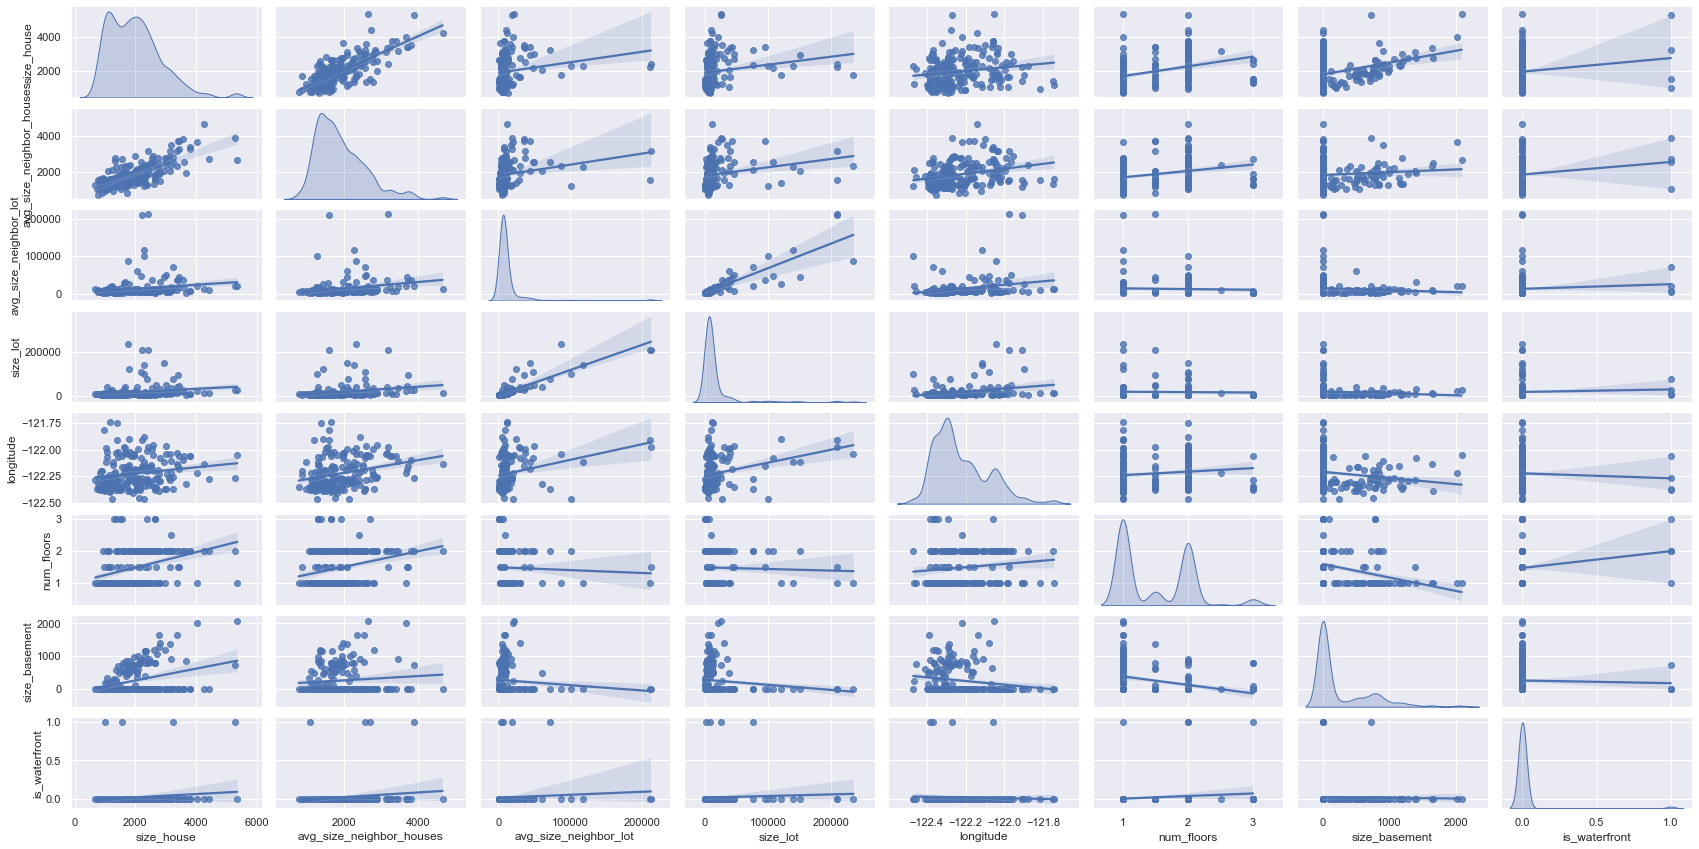

In [9]:
seed = 123

sample_size = 200

hose_prices_sample = house_prices[main_features].sample(sample_size, 
                                                        random_state = seed
                                                       )

sns.pairplot(hose_prices_sample, 
             height = 1.5, 
             aspect = 2, 
             diag_kind = 'kde', 
             kind = 'reg',
             diag_kws = {'bw': 0.2}
            )

#### Vamos analisar como evoluiu, ao longo dos anos, o preço por medida de área dos imóveis.

In [10]:
house_prices['price_area'] = house_prices['price'] / house_prices['size_house']

#### Vamos também experimentar as variáveis categóricas.

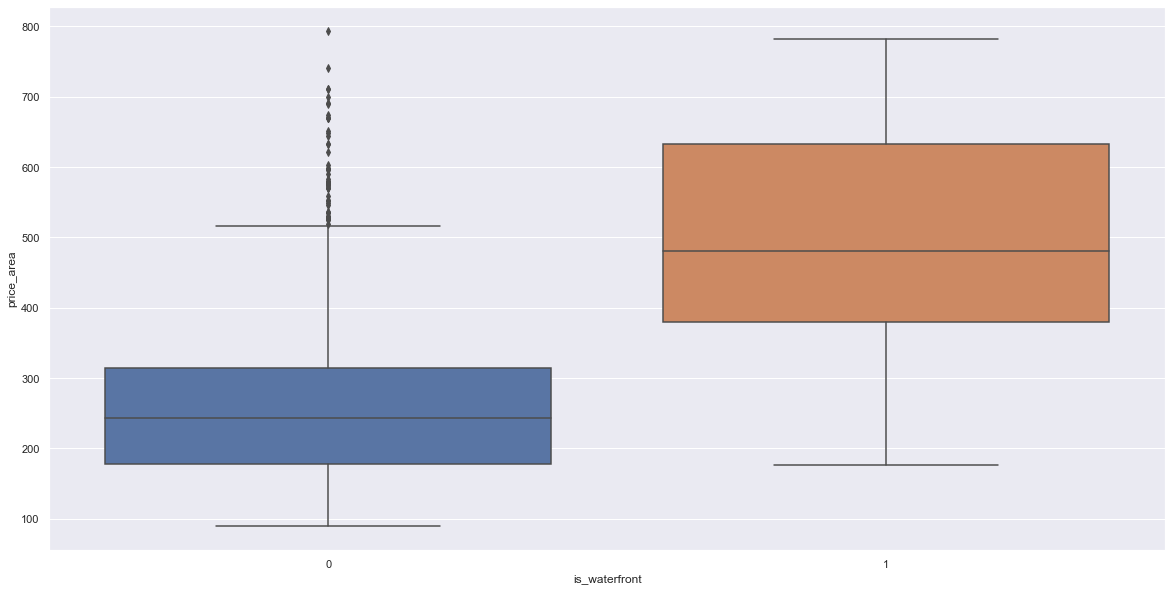

In [11]:
plt.figure(figsize = (20,10))
sns.boxplot(x = 'is_waterfront', 
            y = 'price_area', 
            data = house_prices
           )
plt.show()

#### O [Teste T](https://towardsdatascience.com/tagged/t-test) é um teste que identifica se duas [amostras](https://towardsdatascience.com/the-5-sampling-algorithms-every-data-scientist-need-to-know-43c7bc11d17c) fazem parte da mesma população. A [hipótese nula](https://www.analyticsvidhya.com/blog/2020/07/hypothesis-testing-68351/#:~:text=the%20match%20data.-,Null%20and%20Alternative%20Hypothesis%20Testing,that%20a%20suspect%20is%20guilty.) é que as duas amostras são da mesma populaçõa. Portanto, se o [p-valor](https://medium.com/@ODSC/the-importance-of-p-values-in-data-science-6cb7c7380881#:~:text=P%2Dvalues%20are%20decimal%20numbers,difference%20between%20the%20two%20groups.) do teste for menor que seu nível de significância $(5\%)$, elas não fazem parte da mesma população. Isso é um indicativo de quanto uma variável categórica poderá contribuir para o seu modelo.

In [12]:
import scipy.stats as stats

resultado = stats.ttest_ind(house_prices[house_prices['is_waterfront'] == 0]['price_area'], 
                            house_prices[house_prices['is_waterfront'] == 1]['price_area'], 
                            equal_var = False)
threshold = 0.05

print(resultado)

if resultado.pvalue < threshold:
    
    print("Não se pode afirmar que as amostras são da mesma população.")
else:
    print("Pode-se afirmar com {} de certeza que as amostras são da mesma população.".format(1 - threshold))
    

Ttest_indResult(statistic=-7.548504940315293, pvalue=6.127347781288245e-08)
Não se pode afirmar que as amostras são da mesma população.


#### Realizamos o teste T para as amostras de preços das casas com e sem frente para para uma porção d'água com o método [`.ttest_ind()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html), que considera uma distribuição bilateral para a hipótese nula de que $2$ amostras independentes têm valores médios (esperados) idênticos. Este teste assume que as populações têm variações idênticas por padrão.

#### Depois plotamos a distribuição dos preços para usando a [estimativa da densidade do kernel](https://medium.com/analytics-vidhya/kernel-density-estimation-kernel-construction-and-bandwidth-optimization-using-maximum-b1dfce127073), com o método [`.kdeplot()`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html).

resultado: Ttest_indResult(statistic=-7.548504940315293, pvalue=6.127347781288245e-08)
Ttest_indResult(statistic=-7.548504940315293, pvalue=6.127347781288245e-08)
Não se pode afirmar que as amostras são da mesma população.


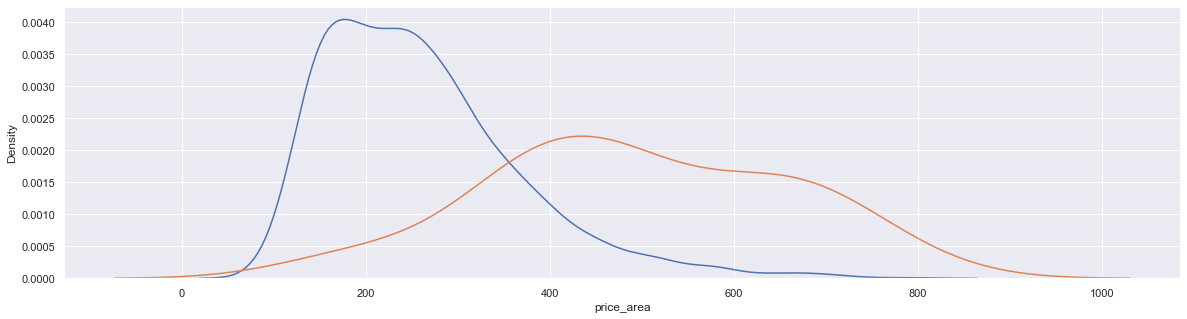

In [13]:
resultado = stats.ttest_ind(house_prices[house_prices['is_waterfront'] == 0]['price_area'], 
                            house_prices[house_prices['is_waterfront'] == 1]['price_area'], 
                            equal_var = False)

print('resultado:', resultado)

threshold = 0.05

print(resultado)

if resultado.pvalue < threshold:
    
    print("Não se pode afirmar que as amostras são da mesma população.")
else:
    print("Pode-se afirmar com {} de certeza que as amostras são da mesma população.".format(1 - threshold))

plt.figure(figsize = (20,5))

sns.kdeplot(data = house_prices[house_prices['is_waterfront'] == 0]['price_area'], 
            label = 'No waterfront'
           )
sns.kdeplot(data = house_prices[house_prices['is_waterfront'] == 1]['price_area'], 
            label = 'With waterfront'
           )

plt.show()

#### Podemos realizar uma contagem do número de casas com e sem frente para para uma porção d'água.

In [14]:
print(house_prices['is_waterfront'].value_counts())

0    1819
1      26
Name: is_waterfront, dtype: int64


#### Podemos também agrupar os dados por código de área, tomando um valor médio dos preços por área. Podemos também ordenar os valores de forma descendente.

In [15]:
zip_group_order = pd.DataFrame(house_prices.groupby('zip')['price_area'].mean().sort_values(ascending = False))

zip_group_orderSample = zip_group_order.sample(n = 30, random_state = 42)
#round(zip_group_orderSample, 2).head(5)

type(zip_group_order)
#round(zip_group_order, 2).head(5)


pandas.core.frame.DataFrame

#### Agora podemos criar um gráfico de violino [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html) para entender como os preços se distribuem por área.

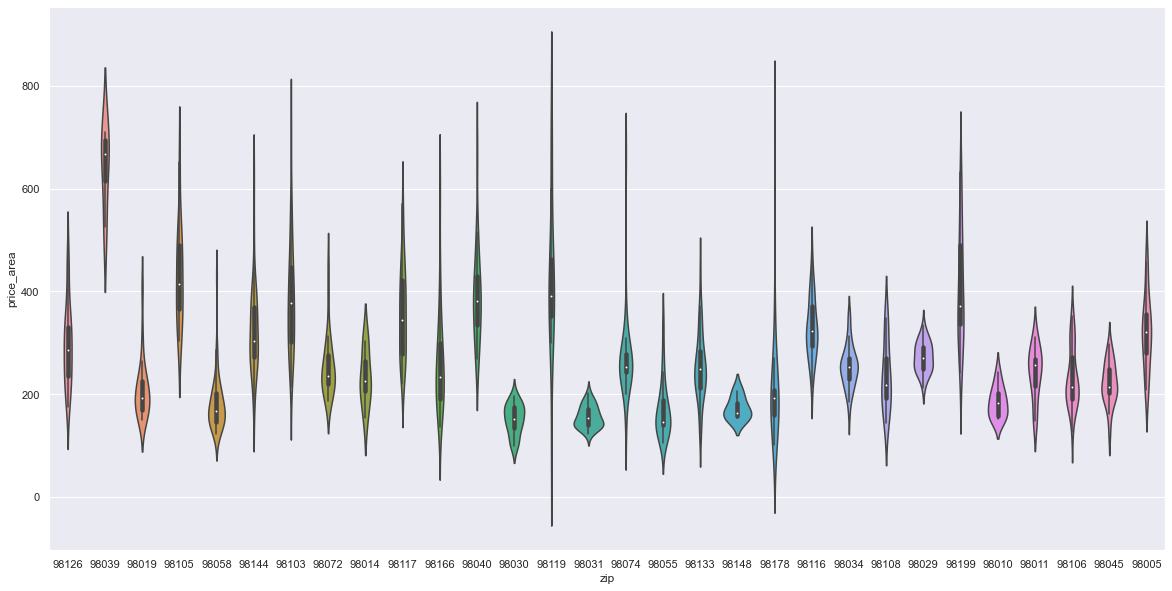

In [16]:
plt.figure(figsize = (20,10))
sns.violinplot(x = 'zip', 
               y = 'price_area', 
               data = house_prices, 
               order = zip_group_orderSample.index
              )
plt.show()

#### Variáveis categóricas com muitas classes podem ser agregadas de diferentes maneiras. Quando códigos postais, em geral, é possível agregar reduzindo uma casa numérica.

In [17]:
house_prices['zip_group'] = house_prices['zip'].astype(str).str[:4]

zip_group_order = house_prices.groupby('zip_group').aggregate({'price_area' : 'mean', 
                                                               'zip_group' : 'count'
                                                              }
                                                             ).sort_values(by = 'price_area',
                                                                           ascending = False
                                                                          )
zip_group_order

,price_area,zip_group
zip_group,,
9810,354.966714,139
9811,343.647354,207
9812,323.438010,90
9819,292.196823,43
9813,284.706099,62
9814,279.609560,72
9817,273.498018,47
9807,264.576707,125
9800,256.148161,217


#### Assim podemos plotar as distribuições, agrupadas por código de área, dos preços das casas.

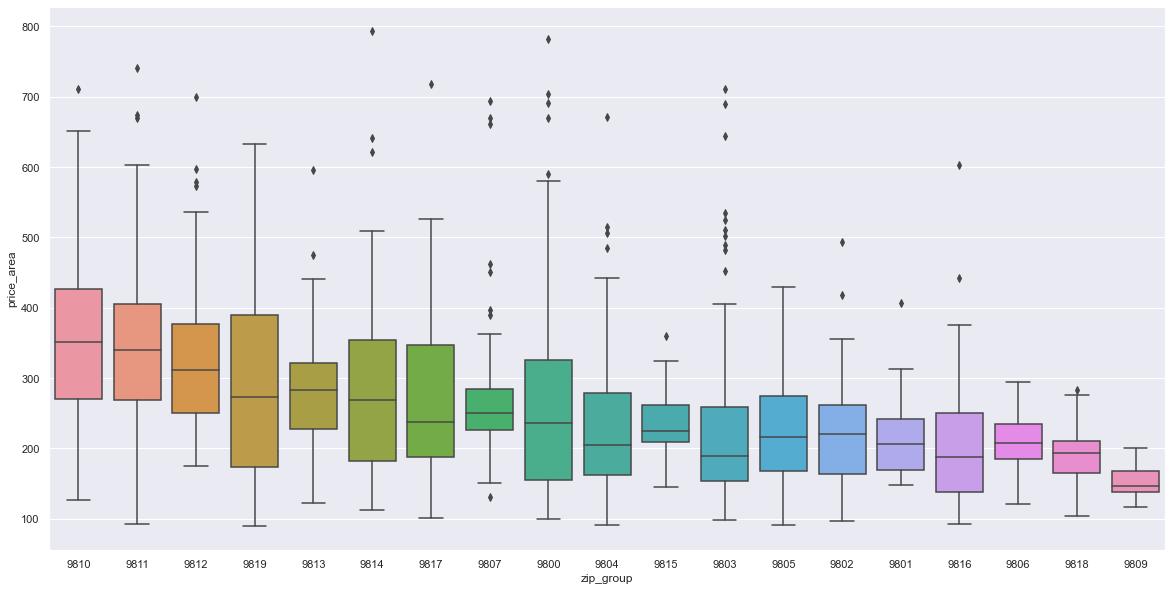

In [18]:
plt.figure(figsize = (20,10))
sns.boxplot(x = 'zip_group', 
            y = 'price_area', 
            data = house_prices, 
            order = zip_group_order.index
           )
plt.show()

#### Se tomarmos três grupos distintos de códigos de área, podemos realizar o Teste-T comparativo entre todas.

Teste sample_a X sample_b:
Não se pode afirmar que 9800 e 9803 são da mesma população.
Teste sample_b X sample_c:
Pode-se afirmar que 9803 e 9805 com 0.95 de certeza que as amostras são da mesma população.
Teste sample_a X sample_c:
Não se pode afirmar que 9800 e 9805 são da mesma população.


Plotamos as amostras sample_a, sample_b e sample_c:


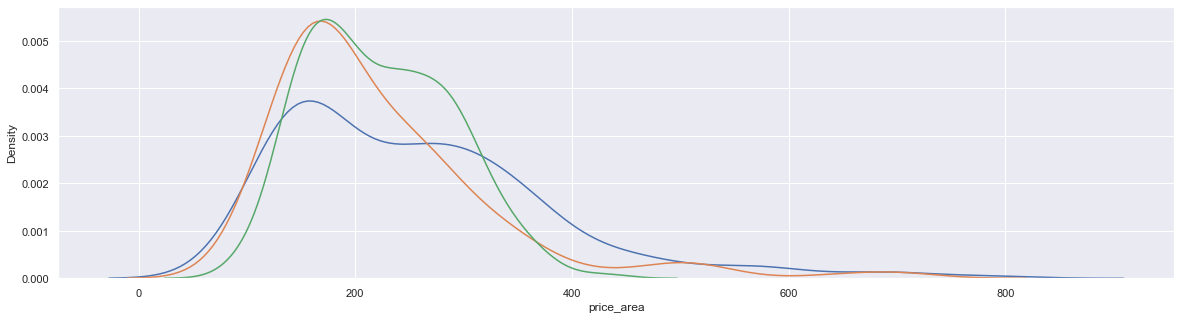

In [19]:
sample_a = house_prices[house_prices['zip_group'] == '9800']['price_area']
sample_b = house_prices[house_prices['zip_group'] == '9803']['price_area']
sample_c = house_prices[house_prices['zip_group'] == '9805']['price_area']

resultado_a_b = stats.ttest_ind(sample_a, 
                                sample_b, 
                                equal_var = False
                               )
resultado_b_c = stats.ttest_ind(sample_b, 
                                sample_c, 
                                equal_var = False
                               )
resultado_a_c = stats.ttest_ind(sample_a, 
                                sample_c, 
                                equal_var = False
                               )
threshold = 0.05

print('Teste sample_a X sample_b:')

if resultado_a_b.pvalue < threshold:

    print("Não se pode afirmar que 9800 e 9803 são da mesma população.")
else:
    print("Pode-se afirmar que 9800 e 9803 com {} de certeza que as amostras são da mesma população.".format(1 - threshold))

print('Teste sample_b X sample_c:')
    
if resultado_b_c.pvalue < threshold:
    
    print("Não se pode afirmar que 9803 e 9805 são da mesma população.")
else:
    print("Pode-se afirmar que 9803 e 9805 com {} de certeza que as amostras são da mesma população.".format(1 - threshold))
    
print('Teste sample_a X sample_c:')    
    
if resultado_a_c.pvalue < threshold:
    
    print("Não se pode afirmar que 9800 e 9805 são da mesma população.")
else:
    print("Pode-se afirmar que 9800 e 9805 com {} de certeza que as amostras são da mesma população.".format(1 - threshold))    

print('\n')

print('Plotamos as amostras sample_a, sample_b e sample_c:')

plt.figure(figsize = (20,5))
sns.kdeplot(sample_a, label = '9800')
sns.kdeplot(sample_b, label = '9803')
sns.kdeplot(sample_c, label = '9805')
plt.show()

#### Criamos as variáveis `'years_since_renovation'` e `'price_log'`.

In [20]:
house_prices["years_since_renovation"] = house_prices["year_built"].max() - house_prices["renovation_date"]
house_prices['price_log'] = np.log(house_prices['price'])

##### Para a primeira estimativa de modelo, vamos focar nas variáveis contínuas e não duplicadas.

In [21]:
cols_drop = ['num_bath', 'is_waterfront', 'num_bed', 'num_floors', 'condition', 'zip', 'zip_group', 
             'year_built', 'renovation_date', 'years_since_renovation', 'price', 'price_log'
            ]

house_prices_cont = house_prices.drop(cols_drop, 
                                      axis = 1
                                     ).copy()

abs(house_prices_cont.corr()['price_area']).sort_values(ascending = False)[1:]

latitude                    0.492296
longitude                   0.241453
avg_size_neighbor_houses    0.079097
avg_size_neighbor_lot       0.073449
size_lot                    0.049257
size_house                  0.043096
size_basement               0.039871
Name: price_area, dtype: float64

## Pre-processing:

#### As melhorias possíveis nesse passo dependerão da revisão do modelo. Para efeito de planejamento aplicaremos tratamentos de [`scaling`](https://medium.com/@stallonejacob/data-science-scaling-of-data-in-python-ec7ad220b339) e a [separação de treino e teste](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/).

#### Mas antes vamos importar as bibliotecas [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) e [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)

In [22]:
import sklearn.preprocessing as skpp
import sklearn.model_selection as skms

#### Vamos separar nossa base de dados em subconjuntos de treino e teste, separando antes um conjunto de atributos e um conjunto de rótulos.

In [23]:
y = house_prices_cont['price_area'].values

Xs = house_prices_cont.drop('price_area', 
                            axis = 1
                           ).values

X_train, X_test, y_train, y_test = skms.train_test_split(Xs, 
                                                         y, 
                                                         random_state = seed, 
                                                         test_size = 0.3
                                                        )

#### E imprimimos os formatos de cada subconjunto.

In [24]:
print(' X train:', X_train.shape, '\n',
      'X test:', X_test.shape, '\n',
      'y train:', y_train.shape, '\n',
      'y test:', y_test.shape
     )

 X train: (1291, 7) 
 X test: (554, 7) 
 y train: (1291,) 
 y test: (554,)


In [25]:
house_prices_cont.columns

Index(['size_house', 'size_lot', 'size_basement', 'latitude', 'longitude',
       'avg_size_neighbor_houses', 'avg_size_neighbor_lot', 'price_area'],
      dtype='object')

#### Podemos realizar um Teste T para checar se os conjuntos de treino e teste pertencem à mesma população.

Pode-se afirmar que price treino e teste com 0.9999 de certeza que as amostras são da mesma população.
Pode-se afirmar que size_house de treino e teste com 0.9999 de certeza que as amostras são da mesma população.


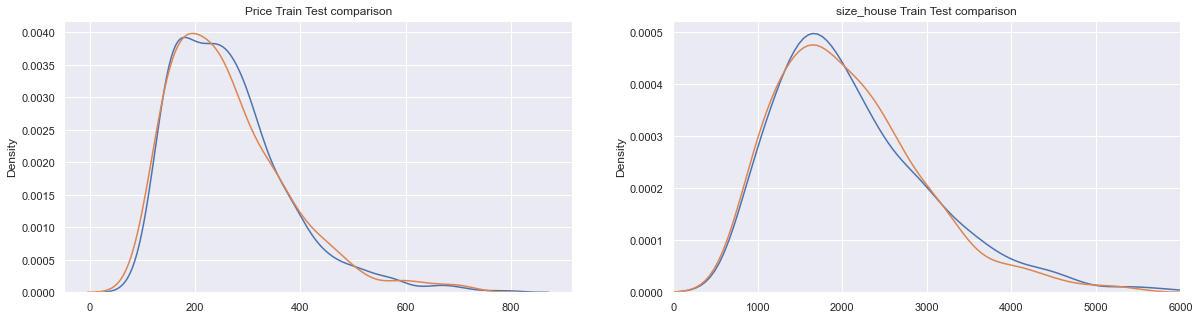

In [26]:
fig, ax = plt.subplots(1, 
                       2, 
                       figsize = (20, 5)
                      )
threshold = 0.0001

sample_a = y_train
sample_b = y_test

resultado_a_b = stats.ttest_ind(sample_a, 
                                sample_b, 
                                equal_var = False
                               )

if resultado_a_b.pvalue < threshold:
    
    print("Não se pode afirmar que price de treino e teste são da mesma população.")
else:
    print("Pode-se afirmar que price treino e teste com {} de certeza que as amostras são da mesma população.".format(1 - threshold))

sns.kdeplot(sample_a, 
            label = 'Train', 
            ax = ax[0]
           )
sns.kdeplot(sample_b, 
            label = 'Test', 
            ax = ax[0]
           )

ax[0].set_title('Price Train Test comparison')

sample_a = X_train[:,0] # size_house
sample_b = X_test[:,0] # size_house

resultado_a_b = stats.ttest_ind(sample_a, 
                                sample_b, 
                                equal_var = False
                               )
threshold = 0.0001

if resultado_a_b.pvalue < threshold:
    
    print("Não se pode afirmar que size_house de treino e teste são da mesma população.")
else:
    print("Pode-se afirmar que size_house de treino e teste com {} de certeza que as amostras são da mesma população.".format(1 - threshold))

sns.kdeplot(sample_a, 
            label = 'Train', 
            ax = ax[1]
           )
sns.kdeplot(sample_b, 
            label = 'Test', 
            ax = ax[1]
           )
ax[1].set_xlim(0,6000)
ax[1].set_title('size_house Train Test comparison')
plt.show()

#### O método [`.jointplot()`](https://seaborn.pydata.org/generated/seaborn.jointplot.html) pode ser usado para plotarmos a disersão entre `'size_house'` e `'price_area'`, com as distribuições de cada variável.

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Anaconda\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


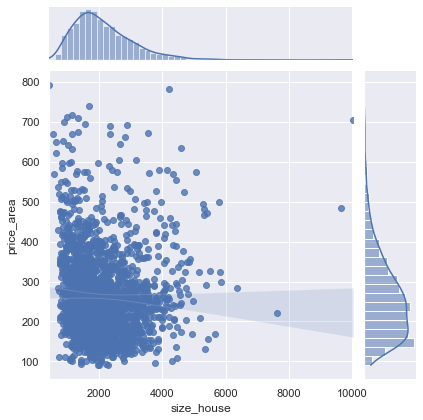

In [27]:
sns.jointplot(house_prices['size_house'], 
              house_prices['price_area'], 
              kind = 'reg');

#### Vamos redimensione alguns atributos com o auxílio do método [`.RobustScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html), que remove a mediana e dimensiona os dados de acordo com o intervalo de quantis. Além disso, nesse momento treinamos nossos dados com o método [`.fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler.fit) e alteramos sua forma com o método [`.transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler.transform), que centraliza e dimensiona os dados.

In [28]:
rscaler = skpp.RobustScaler()
rscaler.fit(X_train)
X_train_rscaler = rscaler.transform(X_train)
X_test_rscaler = rscaler.transform(X_test)

## Modelagem

#### Nesse momento queremos gerar um primeiro modelo e suas saídas (coeficientes, valores preditos, performance, etc), mais adiante investiremos mais tempo analisando esses resultados.

#### Vamos instanciar um modelo de regressão com a biblioteca [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/linear_model.html), que define um conjunto de métodos destinados à regressão em que se espera que o valor do rótulo seja uma [combinação linear](https://www.statlect.com/matrix-algebra/linear-combinations) dos atributos.

#### Ajustamos  modelo aos dados com o método [`.fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit).

<!---# %load solucao4.3.1.py
-->
### Treinamento

In [29]:
import sklearn.linear_model as lm

In [30]:
model_lr = lm.LinearRegression()

model_lr.fit(X_train_rscaler, 
             y_train
            )

LinearRegression()

#### Realizamos então a previsão dos valores com o método [`.predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) e definimos os pesos ou coeficientes que cada variável recebeu no modelo.

In [31]:
y_pred = model_lr.predict(X_train_rscaler)

features_names = house_prices_cont.drop('price_area', 
                                        axis = 1
                                       ).columns


weights = pd.DataFrame(model_lr.coef_,index = features_names, 
                       columns = ['weight']
                      )

intercept = model_lr.intercept_

resid_train = y_pred - y_train

### Análise dos resultados.


#### Vamos verificar quais variáveis tiveram mais peso, identificar onde o modelo erra mais. É importante observar outras métricas de erro, como [r-quadrado](https://www.investopedia.com/terms/r/r-squared.asp#:~:text=To%20calculate%20the%20total%20variance,you%20have%20the%20R%2Dsquared.), [RMSE](https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/), etc.

<!---# %load solucao4.3.2.1.py-->
### Coeficientes

In [32]:
print('Pesos:')

display(weights)

print('Intercept:', round(intercept, 2))

Pesos:


,weight
size_house,-35.394550
size_lot,1.783144
size_basement,4.655951
latitude,77.314491
longitude,-35.477673
avg_size_neighbor_houses,40.295958
avg_size_neighbor_lot,-1.642694


Intercept: 269.1


#### Usamos o método [`.normaltest()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html), testar se a amostra difere de uma distribuição normal. Esta função testa a hipótese nula de que uma amostra vem de uma distribuição normal. É baseado no teste de D’Agostino e Pearson [1](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#r7bf2e556f491-1), [2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#r7bf2e556f491-2) que combina inclinação e curtose para produzir um teste abrangente de normalidade.

In [33]:
from scipy import stats

def normal(df, col, threshold = 0.05):
    try:
        zscore, p_value = stats.normaltest(df[col])
        #print('p_value:', p_value)
        #print("stats.normaltest(df['{}']):".format(col), stats.normaltest(df[col]))
        
        if p_value < threshold:
            result = 'not_normal'
        else:
            result = 'normal' 
    except:
        zscore = p_value = np.nan
        result = 'not_applicable'
    return result



#### A seguir definimos uma função que realiza o cálculo do [intervalo inter quartil](https://www.sciencedirect.com/topics/computer-science/interquartile-range) e detecta os [outliers](A Brief Overview of Outlier Detection Techniques) de um determinada coluna.

In [34]:
def outliers_count_IQR(df, col):
    try:
        if len(df[col].unique()) > 2: # if para eliminar features binárias
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr_range = q3 - q1
            lower = q1 - 1.5 * iqr_range
            upper = q3 + 1.5 * iqr_range
            out_low = df[df[col] < lower].count()[0]
            out_up = df[df[col] > upper].count()[0]
            outliers = out_low + out_up
            outliers_perc = round(outliers / df.shape[0], 
                                  2
                                 )
        else:
            outliers = np.nan
            outliers_perc = np.nan
    except:
        outliers = np.nan
        outliers_perc = np.nan
        
    #print('outliers:', outliers, 'outliers_perc:', outliers_perc)
    return outliers, outliers_perc

#### Podemos realizar mais um pouco de estatística, contando o númeoro de valores núlos, sua porcentagem em referência ao `dataset`, checando os tipos e realizando contagens.

#### Verificamos também a contagem dos elementos únicos, as médias, mínimos e máximos, o desvio padrão, a contagem de `outliers`

In [35]:
def EDA_morestats(df):
    eda_df = {}
    eda_df['Amount_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Amount_Data'] = df.count()
    # Outro ponto para ser verificado, porque para criar a coluna com a quantidade de valores unicos por coluna
    # Não utilizei a função df.unique() 
    colunas = df.columns.tolist()
    eda_df['Amount_Unique'] = pd.Series(map(lambda x: len(df[x].unique().tolist()), 
                                            colunas), 
                                        index = colunas
                                       )
    
    eda_df['Mean'] = df.mean().round(3)
    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['STD'] = df.std().round(3)
    eda_df['Normality'] = pd.Series(map(lambda x: normal(df, 
                                                         x
                                                        ), 
                                        colunas), 
                                    index = colunas
                                   )
    eda_df['Amount_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[0], 
                                              colunas
                                             ), 
                                          index = colunas
                                         )
    eda_df['%_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[1], 
                                         colunas
                                        ), 
                                     index = colunas
                                    )
    df = pd.DataFrame(eda_df)
    #df.loc[colunas,:].head()
    return df.loc[colunas,:]

#### Vamos eliminar a coluna `price_area` de nosso subconjunto de treino.

In [36]:
train_data = pd.DataFrame(X_train_rscaler)

train_data.columns = house_prices_cont.drop('price_area', 
                                            axis = 1
                                           ).columns.to_list()

EDA_morestats(train_data)

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Mean,Min,Max,STD,Normality,Amount_Outliers,%_Outliers
size_house,0,0.0,float64,1291,401,0.169,-1.272349,6.735967,0.807,not_normal,32,0.02
size_lot,0,0.0,float64,1291,1045,1.247,-1.200715,84.480082,6.161,not_normal,150,0.12
size_basement,0,0.0,float64,1291,160,0.533,0.000000,4.900901,0.831,not_normal,45,0.03
latitude,0,0.0,float64,1291,1291,-0.063,-1.803413,0.985650,0.664,not_normal,0,0.00
longitude,0,0.0,float64,1291,1291,0.084,-1.433276,2.651874,0.703,not_normal,18,0.01
avg_size_neighbor_houses,0,0.0,float64,1291,312,0.152,-1.247166,4.410431,0.800,not_normal,44,0.03
avg_size_neighbor_lot,0,0.0,float64,1291,992,1.023,-1.392741,76.024132,5.349,not_normal,136,0.11


#### Agregamos os valores de máximo e mínimo ao `dataset` com os pesos dos atributos e definimos uma função que calcula os valores dos valores mínimos e máximos de um atributo, quando comparados com seus respectivos pesos.

In [37]:
weights_merge = weights.merge(EDA_morestats(train_data)[['Min', 
                                                         'Max'
                                                        ]
                                                       ], 
                              left_index = True, 
                              right_index = True
                             )

def min_max(row):
    if row[0] < 0:
        result = row[0] * row[1]
#        print(row[0], row[1], result)
    else:
        result = row[0] * row[2]
#        print(row[0], row[2], result)
    return result

weights_merge['Max_val'] = weights_merge.apply(lambda x: min_max(x), 
                                               axis = 1
                                              ) 

display(weights_merge.round(2))

print('Intercept:', round(intercept, 2))

,weight,Min,Max,Max_val
size_house,-35.39,-1.27,6.74,45.03
size_lot,1.78,-1.20,84.48,150.64
size_basement,4.66,0.00,4.90,22.82
latitude,77.31,-1.80,0.99,76.21
longitude,-35.48,-1.43,2.65,50.85
avg_size_neighbor_houses,40.30,-1.25,4.41,177.72
avg_size_neighbor_lot,-1.64,-1.39,76.02,2.29


Intercept: 269.1


#### Verificamso o quanto o peso de cada atributo se afasta de zero.

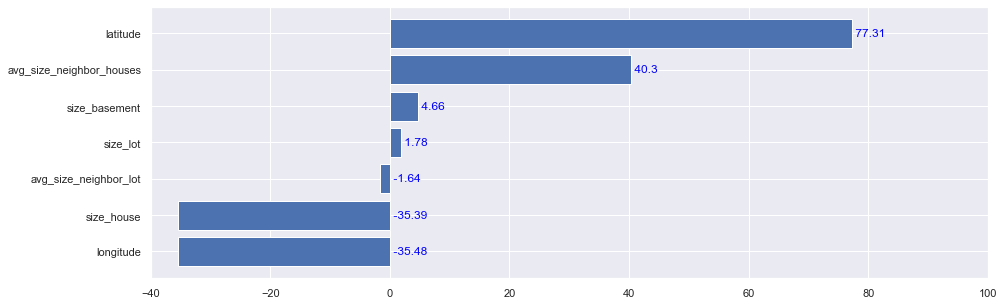

In [38]:
weights = weights.sort_values(by = 'weight')

plt.figure(figsize = (15, 5))

plt.barh(weights.index, 
         weights['weight']
        )

plt.xlim(-40, 100)

for i, v in enumerate(weights['weight']):
    if v > 0:
        plt.text(v, i, " "+str(round(v, 2)), 
                 color = 'blue', 
                 va = 'center'
                )
    else:
        plt.text(0, i, " "+str(round(v, 2)), 
                 color = 'blue', 
                 va = 'center'
                )

#### Erro e resíduos

<!---# %load solucao4.3.2.2.py-->

<b><i><u><font size='4'>DEFINIÇÕES E MÉTRICAS:</b><p>
    1) <b>Resíduo</b>: é a diferença entre o valor previsto e o valor real. Também pode ser chamado de erro, mas em geral usamos resíduo para a diferença e erro para descrever o conjunto do resultado.<p>
    2) <b>MSE</b>: <i>mean squared error</i> ou média dos erros quadráticos. É a média da soma dos quadrados dos erros. Ao fazer o quadrado do erro, é possível acumular os erros positivos e negativos. É uma métrica de erro própria ao modelo, pois depende da ordem de grandeza da variável. O MSE de um modelo para prever preços por m2 não compara com o MSE de um modelo para prever preço total.<p>
    3) <b>RMSE</b>: <i>root mean squared error</i> ou raiz da média dos erros quadráticos. Aplica a raiz na métrica anterior. Como a média é extraída antes de aplicar a raiz, essa métrica dá mais peso a erros maiores. Ou seja, resíduos com valores altos terão a sua influência na métrica elevada ao quadrado. Como você quer um modelo que reduza seu erro, se utilizar o RMSE para otimizar, você buscará meios para reduzir os erros extremos.<p>
    4) <b>MAE</b>: <i> mean absolute error</i> ou média absoluta dos erros. Por fazer a diferença absoluta, não penaliza erros maiores. Se seu modelo não precisa prever bem outliers ou não possui outliers, pode ser adequada.<p>
    5) <b>R2</b>: é uma medida do quão melhor o seu modelo é em relação à uma média simples dos dados (modelo mais simples possivel). Calcula-se o erro desse modelo simples através do MSE considerando como valor predito a média dos dados. Daí divide-se o MSE do modelo pelo MSE dos dados. A diferença desse resultado para 1 é o R2. Quanto menor for o MSE do modelo, mais próxima de zero a divisão estará e mais próximo de 1 o R2 estará. Quanto maior for o seu MSE, menor será seu R2. Um R2 de 0.0 significa que seu modelo é tão bom quanto assumir a média dos valores. Um R2 de 1 significa que seu modelo captura tão bem os valores reais, que ele praticamente não erra, independente da relação com o MSE simples. O R2 nunca pode ser maior que 1 mas pode assumir valores negativos, pois seu modelo pode ser pior do que a média para prever os valores. Uma grande vantagem do R2 é que ele não tem escala, portanto é uma métrica que permite a comparação de modelos distintos.<p>
    6) <b>MAPE</b>: <i> mean absolute percentage error</i> ou média absoluta dos erros percentuais. Elimina o efeito escala da variável target. Contudo, como executa uma divisão, valores muito próximos à zero da variável target tendem a gerar um erro muito maior. Além disso, o efeito gerado por erros negativos é superestimado em relação aos erros positivos.<p>
    7) <b>MPE</b>: <i> mean percentage error</i> ou média dos erros percentuais. Também elimina o efeito escala da variável target. Com base nos argumentos para o MSE, é contra-intuivo acreditar que o MPE seja útil. Contudo, como é um valor percentual, ele acaba sendo um indicador do quanto seu modelo está enviesado para erros positivos ou negativos.<p>
    8) <b>Overfit e underfit</b>: <i> overfit</i> é o comportamento que o modelo assume ao ajustar exageradamente aos dados de treino, de tal forma que sua performance com dados de teste é muito inferior. Diz-se que o modelo não 'generalizou' o suficiente. <i> underfit</i> É quando seu modelo não conseguiu representar suficientemente bem os dados.

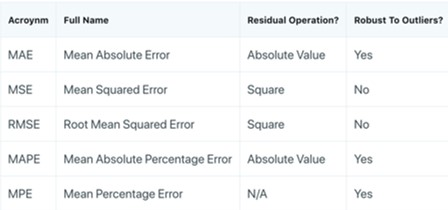

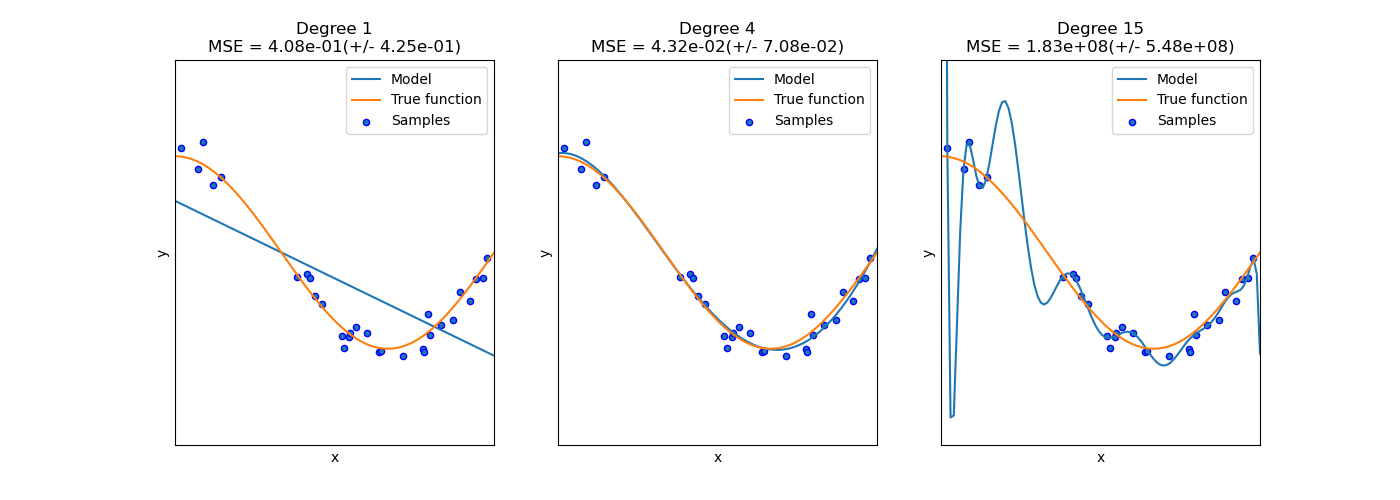

In [39]:
from IPython.display import Image

display(Image(filename = 'table.jpg'), 
        Image(filename = 'overfit.png')
       )

#### Comparamos as distribuições de rótulos calculados e observados.

C:\Anaconda\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


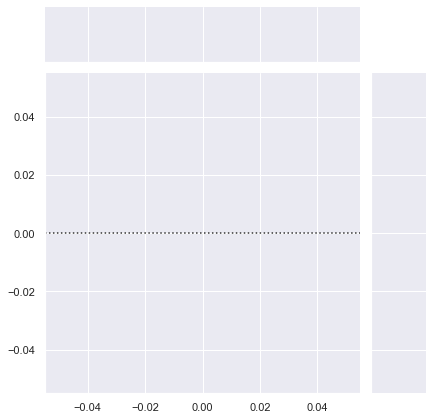

In [40]:
sns.jointplot(x = y_train, 
              y = y_pred, 
              kind = 'resid'
             ).set_axis_labels("");

#### A seguir checamos o número de atributos do modelo e também o subconjunto reescalonado de atributos.

In [41]:
print('Features no modelo:', len(model_lr.coef_))
indice = 20

print('Valores das features para o exemplo de índice', indice)

X_train_rscaler[indice, ]

Features no modelo: 7
Valores das features para o exemplo de índice 20


array([-0.93139293, -0.45165134,  0.        , -0.25646378, -0.17008617,
       -0.8276644 , -0.47393927])

#### Podemos agora comaprar o modelo calculado com o previsto pelo método [`.predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict)

In [42]:
y_calc = 0

for i in range(len(model_lr.coef_)):
    y_calc += model_lr.coef_[i] * X_train_rscaler[indice, i]    
#    print('model_lr.coef_[i]:', model_lr.coef_[i])
#    print('model_lr.intercept_:', model_lr.intercept_)    

y_calc += model_lr.intercept_
    
print(' Y do modelo:', round(y_pred[indice], 2), '\n', 
      'Y calculado com coeficientes:', round(y_calc, 2)
     )

 Y do modelo: 254.9 
 Y calculado com coeficientes: 254.9


#### O [produto escalar](https://www.mathsisfun.com/algebra/vectors-dot-product.html) entre os vetores de atributos e de coeficientes angulares é calculado a seguir, com a ajuda do método [`.dot()`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html).

In [43]:
round(np.dot(X_train_rscaler[0,], 
             model_lr.coef_
            ) 
      + model_lr.intercept_, 
      2
     )

333.91

#### E a seguir checamos algumas métricas de qualidade do modelo.

In [44]:
print(' Y real:   ',round(float(y_train[indice]), 2), '\n'
     ' Y predito:', round(y_pred[indice], 2),'\n',
     'Erro abs: ', round(y_train[indice] - y_pred[indice], 2),'\n',
     'Erro %: ', round(100 * (y_train[indice] - y_pred[indice]) / y_train[indice], 2)
     )

 Y real:    237.8 
 Y predito: 254.9 
 Erro abs:  -17.09 
 Erro %:  -7.19


#### A soma dos [resíduos](https://www.statisticshowto.com/residual/#:~:text=A%20residual%20is%20the%20vertical,are%20below%20the%20regression%20line.&text=In%20other%20words%2C%20the%20residual,explained%20by%20the%20regression%20line.), a diferença entre o previsto e o real, é apresentada a seguir.

In [45]:
y_error = 0

for i in range(len(y_pred)):
    y_error += y_pred[i] - y_train[i]

round(y_error, 2)

-0.0

#### A raiz da média da soma dos quadrados (Root Mean Squared Error - RMSE) também é calculada e comparada com o método [`.mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [46]:
y_error = 0


for i in range(len(y_pred)):
    y_error += (y_pred[i] - y_train[i])**2 

y_error /= len(y_pred)

print('MSE:', round(y_error, 2))

y_error **= (1/2)

print('RMSE:', round(y_error, 2))


import sklearn.metrics as skme

round(skme.mean_squared_error(y_train, y_pred) ** (1 / 2), 2)

MSE: 8266.28
RMSE: 90.92


90.92

#### Calculamos ainda o coeficiente de determinação (R-quadrado)

In [47]:
y_error = 0
y_error_media = 0

for i in range(len(y_pred)):
    y_error += (y_pred[i] - y_train[i]) ** 2 


y_error /= len(y_pred)

print('MSE modelo:', round(y_error, 2))

for i in range(len(y_train)):

    y_error_media += (y_train[i] - np.mean(y_train)) ** 2 

y_error_media /= len(y_train)

print('MSE média:', round(y_error_media, 2))

r2 = 1 - y_error / y_error_media

print('R2:',round(r2, 2))

MSE modelo: 8266.28
MSE média: 12137.71
R2: 0.32


#### O método [.score()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) é usado para calcular o coeficiente de determinação.

In [48]:
r2_train = round(model_lr.score(X_train_rscaler, 
                                y_train), 
                 2
                )
r2_train

0.32

In [49]:
r2_test = round(model_lr.score(X_test_rscaler, 
                               y_test
                              ), 
                2
               )
r2_test

0.32

#### A seguir plotamos os valores de treino e observados para os rótulos.

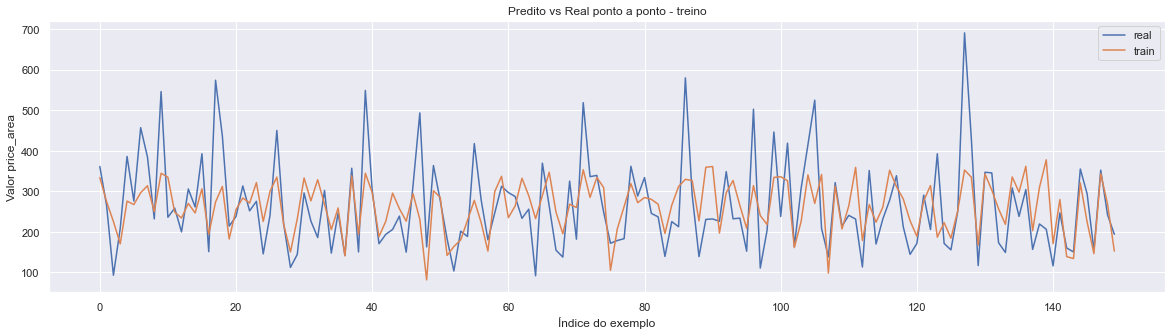

In [50]:
indices = list(range(len(y_pred)))

plt.figure(figsize = (20, 5))

plt.plot(indices[0 : 150], 
         y_train[0 : 150], 
         label = 'real'
        )
plt.plot(indices[0 : 150], 
         y_pred[0 : 150], 
         label = 'train'
        )
plt.title('Predito vs Real ponto a ponto - treino')
plt.ylabel('Valor price_area')
plt.xlabel('Índice do exemplo')
plt.legend()
plt.show()

#### A seguir plotamos os valores de teste e observados para os rótulos.

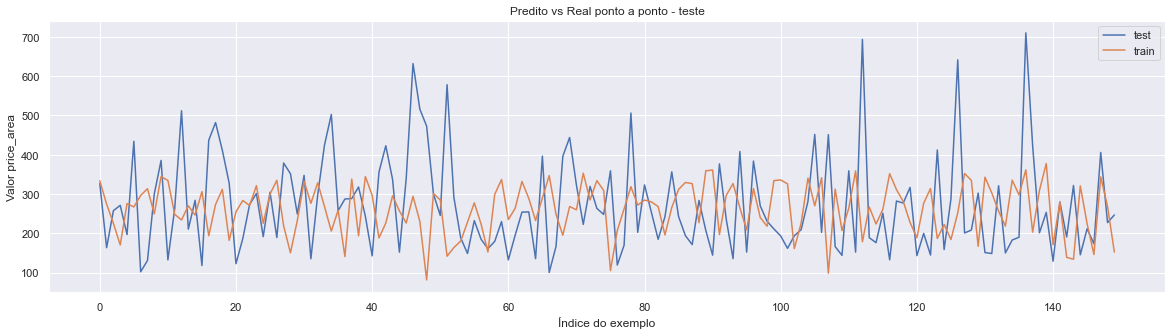

In [51]:
y_pred_test = model_lr.predict(X_test_rscaler)

indices = list(range(len(y_pred_test)))

plt.figure(figsize = (20,5))
plt.plot(indices[0 : 150], 
         y_test[0 : 150], 
         label = 'test'
        )
plt.plot(indices[0 : 150], 
         y_pred[0 : 150], 
         label = 'train'
        )
plt.title('Predito vs Real ponto a ponto - teste')
plt.ylabel('Valor price_area')
plt.xlabel('Índice do exemplo')
plt.legend()
plt.show()

#### Plotamos a seguir a distribuição dos resíduos calculados com  o método [`.normaltest()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html), que teste se uma amostra difere de uma distribuição normal.

Hipótese nula do teste de normalidade: a distribuição em questão é normal
p-value: 0.0


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


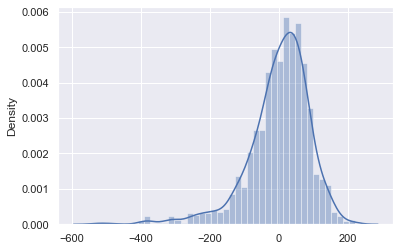

In [52]:
print('Hipótese nula do teste de normalidade: a distribuição em questão é normal')
print('p-value:', round(stats.normaltest(resid_train)[1], 4))
sns.distplot(resid_train)
plt.show()

#### Repetimos o teste anterior em comparação a uma distribuição normalizada dos resíduos.

p-value residuals: 0.0
p-value if normal: 0.0414


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


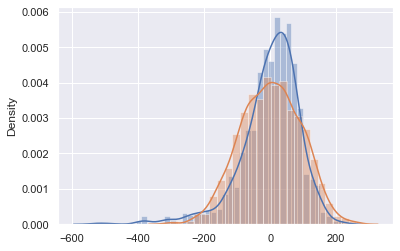

In [53]:
teorical_normal = np.random.normal(loc = np.mean(resid_train), 
                                   scale = np.std(resid_train), 
                                   size = resid_train.shape[0]
                                  )
print('p-value residuals:', round(stats.normaltest(resid_train)[1], 4))
print('p-value if normal:', round(stats.normaltest(teorical_normal)[1], 4))

sns.distplot(resid_train)
sns.distplot(teorical_normal)
plt.show()

#### Plotamos o resíduo de nossos pontos com o método [`'probplot()'`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html), que calcula quantis para um gráfico de probabilidade e, opcionalmente, plota o gráfico.

In [54]:
#plt.hist(resid_train);

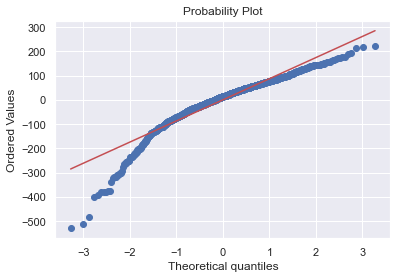

In [55]:
fig = plt.figure()

stats.probplot(resid_train, 
               plot = plt
              )

plt.show()

### Conclusões.

<!---# %load solucao4.3.3.py
## ----------------------------- ##
## ---- dividir celula aqui ---- ##
## ----------------------------- ##-->
- O modelo parece não estar estimando corretamente valores em extremos inferiores. Isso pode ser devido ao `scalling` ou por possuir uma não-linearidade não capturada pelo modelo.

- Coordenadas de latitude e longitude estão impactando de forma significativa o modelo, considerando seus pesos. Contudo, lembremos do mapa, em que o lugar mais caro é o centro da cidade. Como é um modelo linear, latitudes acima do centro fazem com que o preço suba, quando deveria cair. Podemos construir uma `feature` para a distância até o centro.

- A partir de agora vamos testar esses efeitos, criando modelos e implementando cada uma das ideias separadamente. Em resumo:

    - Substituir `price_area` por `price_log`, uma vez que `price_area` eliminou a importância da área no modelo e não capturou a não linearidade do preço.

    - Calcular a distância para o centro.

    - Modificar o `scaler` para `min_max`, pois o modelo precisa se ajustar para aos preços extremos.

    - Incluir as variáveis categóricas, provavelmente adotando [`binary_encoder`](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/#:~:text=Binary%20encoding%20is%20a%20combination,is%20split%20into%20different%20columns.) para evitar uma matriz muito esparsa.

<!---## ----------------------------- ##
## ---- dividir celula aqui ---- ##
## ----------------------------- ##-->
## Reiterando na modelagem

#### Vamos guardar as informações do modelo atual para futura comparação.

In [56]:
models_summary = []
summary = {'target:': 'price_area',
           'features': features_names.to_list(),
           'scaler': 'RobustScaler',
           'weights': weights.weight.to_list(),
           'intercept': intercept,
           'score_train': r2_train,
           'score_test': r2_test
          }
models_summary.append(summary)
models_summary

[{'target:': 'price_area',
  'features': ['size_house',
   'size_lot',
   'size_basement',
   'latitude',
   'longitude',
   'avg_size_neighbor_houses',
   'avg_size_neighbor_lot'],
  'scaler': 'RobustScaler',
  'weights': [-35.477672768145126,
   -35.394550378555124,
   -1.6426942056838834,
   1.7831441665354302,
   4.65595111866554,
   40.29595750327398,
   77.31449086199382],
  'intercept': 269.103733559814,
  'score_train': 0.32,
  'score_test': 0.32}]

#### Definimos uma função para realizar a [seleção de atributos](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/), seu [pré-processamento](https://towardsdatascience.com/data-pre-processing-techniques-you-should-know-8954662716d6), além da modelagem dos pontos.

In [57]:
def model_build(data, target, drops, scale_method = 'RobustScaler', seed = 123, test_size = 0.3, verbose = False):
    # feature selection
    df = data.copy()
    df.drop(cols_drop, 
            axis = 1, 
            inplace = True
           )

    # pre-processing
    ## train/test split
    y = df[target].values
    Xs = df.drop(target, 
                 axis = 1
                ).values
    X_train, X_test, y_train, y_test = skms.train_test_split(Xs, y, random_state = seed, test_size = test_size)

    if scale_method == 'RobustScaler':
        scaler = skpp.RobustScaler()
    elif scale_method == 'MinMaxScaler':
        scaler = skpp.MinMaxScaler()
    elif scale_method =='StandardScaler':
        scaler = skpp.StandardScaler()
    elif scale_method == 'MaxAbsScaler':
        scaler = skpp.MaxAbsScaler()
    
    scaler.fit(X_train)
    X_train_rscaled = scaler.transform(X_train)
    X_test_rscaled = scaler.transform(X_test)

    # modelling
    model_lr.fit(X_train_rscaled, 
                 y_train
                )
    
    y_pred_train = model_lr.predict(X_train_rscaled)
    
    features_names = df.drop(target, 
                             axis = 1
                            ).columns
    
    weights = pd.DataFrame(model_lr.coef_, 
                           index = features_names, 
                           columns = ['weight']
                          )
#    print('weights')
#    print(weights)
    
    intercept = model_lr.intercept_
    
    y_pred_test = model_lr.predict(X_test_rscaled)
    
    r2_train = round(model_lr.score(X_train_rscaled, y_train), 2)
    
    r2_test = round(model_lr.score(X_test_rscaled, y_test), 2)
    
    summary = {'target:': target,
               'features': features_names.to_list(),
               'scaler': scale_method,
               'weights': weights['weight'].to_list(),
               'intercept': intercept,
               'score_train': r2_train,
               'score_test': r2_test
              }
    
    if verbose:
        print('Train:', summary['score_train'],'\n',
              'Test:', summary['score_test']
             )
        
        weights = weights.sort_values(by = 'weight')
        
        plt.figure(figsize = (15, 5))
        
        plt.barh(weights.index, 
                 weights['weight']
                )
        
        for i, v in enumerate(weights['weight']):
            if v > 0:
                plt.text(v, i, " "+str(round(v,2)), 
                         color = 'blue', 
                         va = 'center'
                        )
            else:
                plt.text(0, i, " "+str(round(v,2)), color = 'blue', va = 'center')

    return summary

<!---## ----------------------------- ##
## ---- dividir celula aqui ---- ##
## ----------------------------- ##-->
### Reiterando - price_log

#### Vamos criar uma coluna `zip_group` para códigos de área da mesma região e a variável `'years_since_renovation'` e plotamos seu histograma.

In [58]:
house_prices['zip_group'] = house_prices['zip'].astype(str).str[:4]
house_prices["years_since_renovation"] = house_prices["year_built"].max() - house_prices["renovation_date"] 

Train: 0.73 
 Test: 0.69


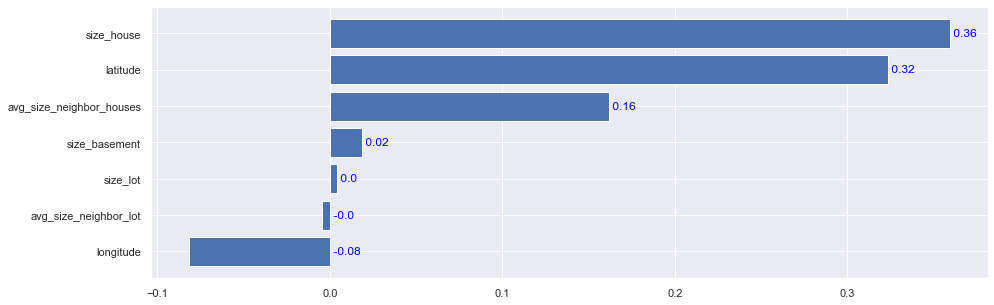

In [59]:
target = 'price_log'

categorical = ['num_bath', 
               'is_waterfront', 
               'num_bed', 
               'num_floors', 
               'condition','zip', 'zip_group'
              ]

year = ['year_built', 
        'renovation_date', 
        'years_since_renovation'
       ]
price = ['price', 
         'price_area'
        ]

cols_drop = categorical
cols_drop.extend(year)
cols_drop.extend(price)

summary = model_build(data = house_prices, 
                      target = target, 
                      drops = cols_drop, 
                      scale_method = 'RobustScaler', 
                      verbose = True
                     )

<!---## ----------------------------- ##
## ---- dividir celula aqui ---- ##
## ----------------------------- ##-->
### Reiterando - scalers

In [60]:
summary = model_build(data = house_prices, 
                      target = target, 
                      drops = cols_drop, 
                      scale_method = 'MinMaxScaler'
                     )

print('Train:',summary['score_train'],'\n'
      'Test:',summary['score_test']
     )

Train: 0.73 
Test: 0.69


In [61]:
target = 'price_log'

categorical = ['num_bath',
               'is_waterfront', 
               'num_bed', 
               'num_floors', 
               'condition', 
               'zip', 
               'zip_group'
              ]

year = ['year_built', 
        'renovation_date', 
        'years_since_renovation'
       ]

price = ['price', 
         'price_area'
        ]

cols_drop = categorical

cols_drop.extend(year)

cols_drop.extend(price)

summary = model_build(data = house_prices, 
                      target = target, 
                      drops = cols_drop, 
                      scale_method = 'StandardScaler'
                     )

print('Train:', summary['score_train'],'\n'
      'Test:', summary['score_test']
     )

Train: 0.73 
Test: 0.69


<!---## ----------------------------- ##
## ---- dividir celula aqui ---- ##
## ----------------------------- ##-->

### Reiterando - lat/long central

#### Usamos o método [`.cut()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) para segmentar e classificar os valores dos dados em compartimentos.

In [62]:
pd.cut(house_prices['latitude'], 
       10
      ).value_counts()

(47.66, 47.718]     304
(47.542, 47.601]    295
(47.484, 47.542]    258
(47.601, 47.66]     246
(47.718, 47.777]    217
(47.307, 47.366]    153
(47.425, 47.484]    150
(47.366, 47.425]    119
(47.249, 47.307]     86
(47.189, 47.249]     17
Name: latitude, dtype: int64

In [63]:
pd.cut(house_prices['latitude'], 10).value_counts().index[0]

Interval(47.66, 47.718, closed='right')

In [64]:
pd.cut(house_prices['latitude'], 10).value_counts().index[0].right

47.718

In [65]:
print(pd.cut(house_prices['latitude'], 10).value_counts().index[1].right - pd.cut(house_prices['latitude'], 10).value_counts().index[1].left)

pd.cut(house_prices['latitude'], 10).value_counts().index[2].right - pd.cut(house_prices['latitude'], 10).value_counts().index[2].left

0.0589999999999975


0.05799999999999983

#### Compartimentamos agora as latitudes e as longitudes em novas variáveis.

In [66]:
house_prices_new = house_prices.copy()
house_prices_new['lat_bins'] = pd.cut(house_prices['latitude'], 10)
house_prices_new['long_bins'] = pd.cut(house_prices['longitude'], 10)

In [67]:
bins = house_prices_new.pivot_table('price_area', 
                                    index = 'lat_bins', 
                                    columns = 'long_bins', 
                                    aggfunc = 'mean'
                                   ).round(2)

reverse_index = sorted(bins.index, 
                       reverse = True
                      )

bins = bins.loc[reverse_index, :]
bins

long_bins,"(-122.516, -122.411]","(-122.411, -122.306]","(-122.306, -122.202]","(-122.202, -122.098]","(-122.098, -121.994]","(-121.994, -121.89]","(-121.89, -121.786]","(-121.786, -121.681]","(-121.577, -121.473]"
lat_bins,,,,,,,,,
"(47.718, 47.777]",NaN,265.19,245.82,251.90,238.01,204.15,406.74,NaN,166.67
"(47.66, 47.718]",NaN,355.88,352.01,292.81,288.93,191.02,NaN,NaN,NaN
"(47.601, 47.66]",NaN,418.47,453.78,307.21,271.10,250.47,153.52,NaN,NaN
"(47.542, 47.601]",361.44,312.66,319.71,302.15,282.46,248.03,234.34,NaN,NaN
"(47.484, 47.542]",286.29,246.13,228.36,213.49,241.28,282.57,209.64,225.25,NaN
"(47.425, 47.484]",217.82,244.69,183.72,177.69,201.97,221.09,184.86,230.86,NaN
"(47.366, 47.425]",294.21,157.50,154.11,155.56,171.20,248.57,NaN,NaN,NaN
"(47.307, 47.366]",292.86,174.52,151.52,160.10,165.89,191.42,NaN,NaN,NaN
"(47.249, 47.307]",NaN,145.64,154.21,155.69,141.93,NaN,NaN,NaN,NaN


#### Geramos um novo [mapa de calor](https://www.crazyegg.com/blog/understanding-using-heatmaps-studies/).

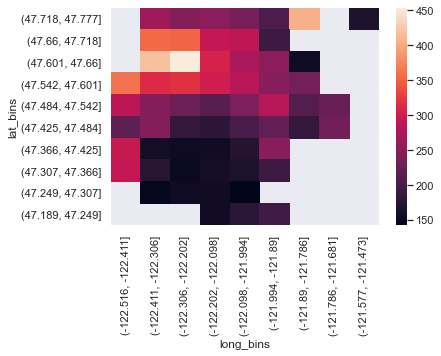

In [68]:
sns.heatmap(bins);

In [69]:
bins_stacked = bins.stack().reset_index().sort_values(by = 0, 
                                                      ascending = False
                                                     ).reset_index().drop('index', 
                                                                          axis = 1
                                                                         )
bins_stacked.head()

,lat_bins,long_bins,0
0,"(47.601, 47.66]","(-122.306, -122.202]",453.78
1,"(47.601, 47.66]","(-122.411, -122.306]",418.47
2,"(47.718, 47.777]","(-121.89, -121.786]",406.74
3,"(47.542, 47.601]","(-122.516, -122.411]",361.44
4,"(47.66, 47.718]","(-122.411, -122.306]",355.88


In [70]:
selected_bin = 0

lat_mean = (bins_stacked.loc[bins_stacked.index == selected_bin, 
                             ['lat_bins']
                            ].values[0][0].left + bins_stacked.loc[bins_stacked.index == selected_bin, 
                                                                                ['lat_bins']
                                                                               ].values[0][0].right) / 2

long_mean = (bins_stacked.loc[bins_stacked.index == selected_bin,['long_bins']].values[0][0].left + bins_stacked.loc[bins_stacked.index == selected_bin,['long_bins']].values[0][0].right)/2
print(lat_mean, long_mean)

47.6305 -122.25399999999999


#### Calculamos a difenreça entre as latitudes observada e o valor médio delas.

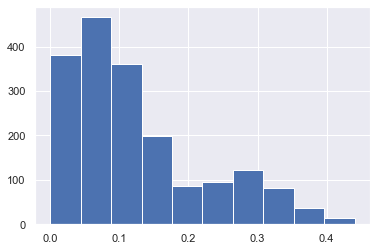

In [71]:
house_prices_new['lat_dif'] = abs(house_prices_new['latitude'] - lat_mean)
house_prices_new['long_dif'] = abs(house_prices_new['longitude'] - long_mean)
house_prices_new['lat_dif'].hist();

#### Aqui vamos definir uma nova variável de rótulo (`target`), definindo as variáveis que abandonaremos, com o método ['.extend()'](https://python-reference.readthedocs.io/en/latest/docs/list/extend.html) e geramos um novo gráfico de barras com os pesos de cda variável. 

Train: 0.78 
 Test: 0.74


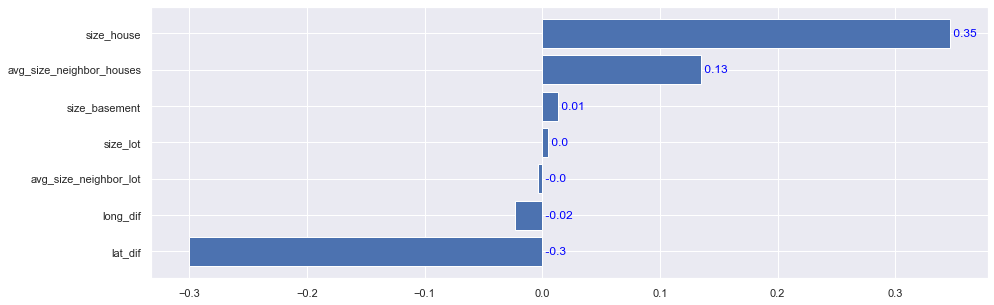

In [72]:
target = 'price_log'

categorical = ['num_bath', 
               'is_waterfront', 
               'num_bed', 
               'num_floors', 
               'condition', 
               'zip', 
               'zip_group'
              ]

year = ['year_built', 
        'renovation_date', 
        'years_since_renovation'
       ]

price = ['price', 
         'price_area'
        ]

lat_long = ['latitude', 
            'longitude', 
            'lat_bins', 
            'long_bins'
           ]

cols_drop = categorical
cols_drop.extend(year)
cols_drop.extend(price)
cols_drop.extend(lat_long)

summary = model_build(data = house_prices_new, 
                      target = target, 
                      drops = cols_drop, 
                      scale_method = 'RobustScaler', 
                      verbose = True
                     )

In [73]:
#type(cols_drop)
#cols_drop

#### Podemos ir mais longe e aperfeiçoar a função geradora dos modelos implementando um parâmetro `'result_full'`, como opção para o armazenamento de outras informações não presentes na definição atual da função, como os resíduos por exemplo.

In [74]:
def model_build(data, target, drops, scale_method = 'RobustScaler', seed = 123, test_size = 0.3, verbose = False, result_full = False):
    # feature selection
    df = data.copy()
    df.drop(cols_drop, 
            axis = 1, 
            inplace = True
           )

    # pre-processing
    ## train/test split
    y = df[target].values
    Xs = df.drop(target, 
                 axis = 1
                ).values
    
    X_train, X_test, y_train, y_test = skms.train_test_split(Xs, y, random_state = seed, test_size = test_size)

    if scale_method == 'RobustScaler':
        scaler = skpp.RobustScaler()
    elif scale_method == 'MinMaxScaler':
        scaler = skpp.MinMaxScaler()
    elif scale_method =='StandardScaler':
        scaler = skpp.StandardScaler()
    elif scale_method == 'MaxAbsScaler':
        scaler = skpp.MaxAbsScaler()        
        print(scale_method)
    
    scaler.fit(X_train)
    X_train_rscaled = scaler.transform(X_train)
    X_test_rscaled = scaler.transform(X_test)

    # modelling
    model_lr.fit(X_train_rscaled, 
                 y_train
                )
    
    features_names = df.drop(target, 
                             axis = 1
                            ).columns
    weights = pd.DataFrame(model_lr.coef_, 
                           index = features_names, 
                           columns = ['weight']
                          )
    intercept = model_lr.intercept_
    r2_train = round(model_lr.score(X_train_rscaled, 
                                    y_train), 
                     2
                    )
    r2_test = round(model_lr.score(X_test_rscaled, 
                                   y_test), 
                    2
                   )

    if result_full:
        y_pred_train = model_lr.predict(X_train_rscaled)
        y_pred_test = model_lr.predict(X_test_rscaled)
        summary = {'target:': target,
                   'features': features_names.to_list(),
                   'scaler': scale_method,
                   'weights': weights.weight.to_list(),
                   'intercept': intercept,
                   'score_train': r2_train,
                   'score_test': r2_test,
                   'y_train': y_train,
                   'y_test': y_test,
                   'y_pred_train': y_pred,
                   'y_pred_test': y_pred_test
                  }
    else:
        summary = {'target:': target,
                   'features': features_names.to_list(),
                   'scaler': scale_method,
                   'weights': weights['weight'].to_list(),
                   'intercept': intercept,
                   'score_train': r2_train,
                   'score_test': r2_test
                  }

    if verbose:
        print('Train:', summary['score_train'],'\n',
              'Test:', summary['score_test'])
        weights = weights.sort_values(by = 'weight')
        plt.figure(figsize = (15, 5))
        plt.barh(weights.index,weights['weight'])

        for i, v in enumerate(weights['weight']):
            if v > 0:
                plt.text(v, i, " "+str(round(v,2)), color = 'blue', va = 'center')
            else:
                plt.text(0, i, " "+str(round(v,2)), color = 'blue', va = 'center')

    return summary

In [75]:
summary = model_build(data = house_prices_new, 
                      target = target, 
                      drops = cols_drop, 
                      scale_method = 'RobustScaler', 
                      result_full = True
                     )

In [76]:
summary.keys()

dict_keys(['target:', 'features', 'scaler', 'weights', 'intercept', 'score_train', 'score_test', 'y_train', 'y_test', 'y_pred_train', 'y_pred_test'])

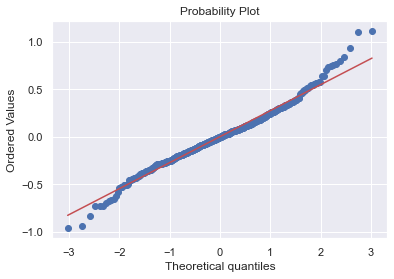

In [77]:
y_test = summary['y_test']
y_pred_test = summary['y_pred_test']
resid_test = y_test - y_pred_test

fig = plt.figure()
stats.probplot(resid_test, plot = plt)
plt.show()

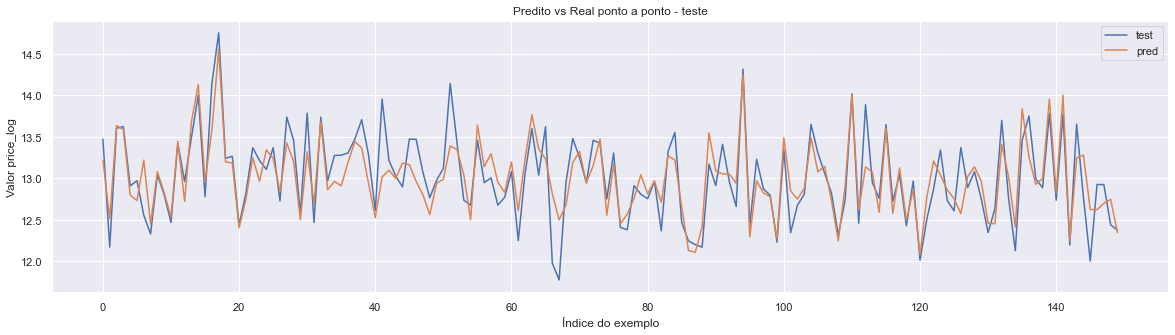

In [78]:
indices = list(range(len(y_pred_test)))

plt.figure(figsize = (20, 5))

plt.plot(indices[0 : 150], 
         y_test[0 : 150], 
         label = 'test'
        )
plt.plot(indices[0 : 150], 
         y_pred_test[0 : 150], 
         label = 'pred'
        )
plt.title('Predito vs Real ponto a ponto - teste')
plt.ylabel('Valor price_log')
plt.xlabel('Índice do exemplo')
plt.legend()
plt.show()

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Anaconda\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


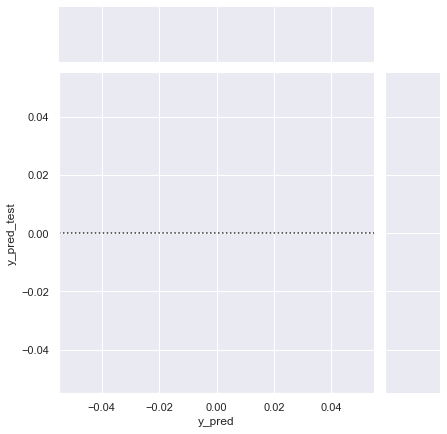

In [79]:
sns.jointplot(y_test, 
              y_pred_test, 
              kind = 'resid'
             ).set_axis_labels("");
plt.xlabel('y_pred')
plt.ylabel('y_pred_test')
plt.show()

# Ainda há melhoramentos que podem ser empregados:

- Testar a inclusão das variáveis categóricas
- Calcular outras métricas. Por exemplo, RMSE e verificar como ela melhora entre as versões. Eventualmente, pode ser um output da função.